<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.4: Sentiment Analysis

This lab performs sentiment analysis on sentiment-labelled sentences using two types of feature extraction - a count vectoriser and TF-IDF vectoriser.

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/about) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotation, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [74]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

Load Yelp, Amazon and Imdb Data into dataframes. Create three column names 'text', 'sentiment' and 'source' (equal to one of 'yelp', 'imdb' or 'amazon' for each dataframe).

Hint: Source is separated by tabs and has no headers.

In [76]:
yelp_text = 'yelp_labelled.txt'
imdb_text = 'imdb_labelled_fixed.txt'
amazon_text = 'amazon_cells_labelled.txt'

# ANSWER

# Load each dataset into a DataFrame
# Specify that the delimiter is a tab and there is no header
yelp_df = pd.read_csv(yelp_text, delimiter='\t', header=None, names=['text', 'sentiment'])
imdb_df = pd.read_csv(imdb_text, delimiter='\t', header=None, names=['text', 'sentiment'])
amazon_df = pd.read_csv(amazon_text, delimiter='\t', header=None, names=['text', 'sentiment'])

In [78]:
yelp_df.head()

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [80]:
# Add the source column to each DataFrame
yelp_df['source'] = 'yelp'
imdb_df['source'] = 'imdb'
amazon_df['source'] = 'amazon'

In [82]:
yelp_df.head()

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [84]:
imdb_df.head()

,text,sentiment,source
0,"A very, very, very slow-moving, aimless movie ...",0,imdb
1,Not sure who was more lost - the flat characte...,0,imdb
2,Attempting artiness with black & white and cle...,0,imdb
3,Very little music or anything to speak of.,0,imdb
4,The best scene in the movie was when Gerardo i...,1,imdb


In [86]:
amazon_df.head()

,text,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon


## Inspect the data

Check your datasets.

In [ ]:
# ANSWER


## Merge the data

Merge all three datasets.

In [88]:
# ANSWER
# Combine all DataFrames into a single DataFrame
combined_df = pd.concat([yelp_df, imdb_df, amazon_df], ignore_index=True)

In [90]:
combined_df.head(10)

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
5,Now I am getting angry and I want my damn pho.,0,yelp
6,Honeslty it didn't taste THAT fresh.),0,yelp
7,The potatoes were like rubber and you could te...,0,yelp
8,The fries were great too.,1,yelp
9,A great touch.,1,yelp


In [92]:
combined_df.tail(10)

,text,sentiment,source
2990,I'm really disappointed all I have now is a ch...,0,amazon
2991,Painful on the ear.,0,amazon
2992,Lasted one day and then blew up.,0,amazon
2993,disappointed.,0,amazon
2994,Kind of flops around.,0,amazon
2995,The screen does get smudged easily because it ...,0,amazon
2996,What a piece of junk.. I lose more calls on th...,0,amazon
2997,Item Does Not Match Picture.,0,amazon
2998,The only thing that disappoint me is the infra...,0,amazon
2999,"You can not answer calls with the unit, never ...",0,amazon


## Prepare the stage
- Load spaCy

In [94]:
nlp = spacy.load('en_core_web_sm')

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international characters
- handle symbols
- handle metadata and embedded information
- handle repetitions (such multiple spaces or newlines)

Clean text.

In [96]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [98]:
# Apply the clean_text function to your dataset.
# ANSWER

combined_df['text'] = combined_df['text'].apply(clean_text)

# Display the first few rows of the cleaned DataFrame
print(combined_df.head())

                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp


## Work the text
Using techniques learned in previous labs, remove StopWords, punctuation, and digits. Entities can be retained. Return the lemmatised form of any remaining words in lower case form.

This removes meaningless information.

In [100]:
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
import string


In [102]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()


In [104]:
# Complete the function
def convert_text(text):
    '''
    Use techniques learned in previous labs.
    1) Remove StopWords, Punctuation and digits.
    2) Retain entities.
    3) Return the lemmatised form of remaining words in lower case form.
    '''

    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove punctuation and digits
    tokens = [word for word in tokens if word.isalpha()]

    # Initialize stop words
    stop_words = set(stopwords.words('english'))

    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Process text with spaCy for entity recognition
    doc = nlp(text)
    entities = set(ent.text.lower() for ent in doc.ents)

    # Lemmatize and retain entities
    lemmatized_tokens = []
    for word in tokens:
        # Lemmatize the word
        lemmatized_word = lemmatizer.lemmatize(word.lower())
        # If the word is an entity, retain it
        if lemmatized_word in entities:
            lemmatized_tokens.append(lemmatized_word)
        else:
            lemmatized_tokens.append(lemmatized_word)

    # Join tokens back into a single string
    cleaned_text = ' '.join(lemmatized_tokens)

    return cleaned_text
    

In [106]:
%%time
combined_df['short'] = combined_df['text'].apply(convert_text)

CPU times: total: 47.5 s
Wall time: 1min 13s


In [108]:
combined_df.sample(10)

,text,sentiment,source,short
321,"Also, the fries are without a doubt the worst ...",0,yelp,also fry without doubt worst fry ever
2322,The Ngage is still lacking in earbuds.,0,amazon,ngage still lacking earbuds
1026,Graphics is far from the best part of the game.,0,imdb,graphic far best part game
1871,The script is horrendously stupid.,0,imdb,script horrendously stupid
863,I love their fries and their beans.,1,yelp,love fry bean
968,We've have gotten a much better service from t...,0,yelp,gotten much better service pizza place next do...
302,The potato chip order was sad... I could proba...,0,yelp,potato chip order sad could probably count man...
467,This is was due to the fact that it took 20 mi...,0,yelp,due fact took minute acknowledged another minu...
1542,"While you don't yet hear Mickey speak, there a...",1,imdb,yet hear mickey speak ton sound effect music t...
1606,The story line is just awful!,0,imdb,story line awful


## Split the dataset

In [110]:
# Features and Labels
X = combined_df['short']
y = combined_df['sentiment']

# Apply a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Create a Bag-of-Words Model

In [112]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [114]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [116]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [118]:
# train the classifier with the training data
classifier.fit(A, y_train)

SVC(kernel='linear', probability=True)

In [120]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [122]:
# make predictions based on the test data
predictions = classifier.predict(B)

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B)[:, 1]

In [124]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7967


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [126]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B)

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B)[:, 1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7967


## Defining a helper function to show results and charts

In [128]:

def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

## Repeating it all for comparison
Repeat the whole lot in one big block using the show_summary_report function.

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

*********
* Count *
*********
Accuracy : 0.7967 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8116 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7796 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8677                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


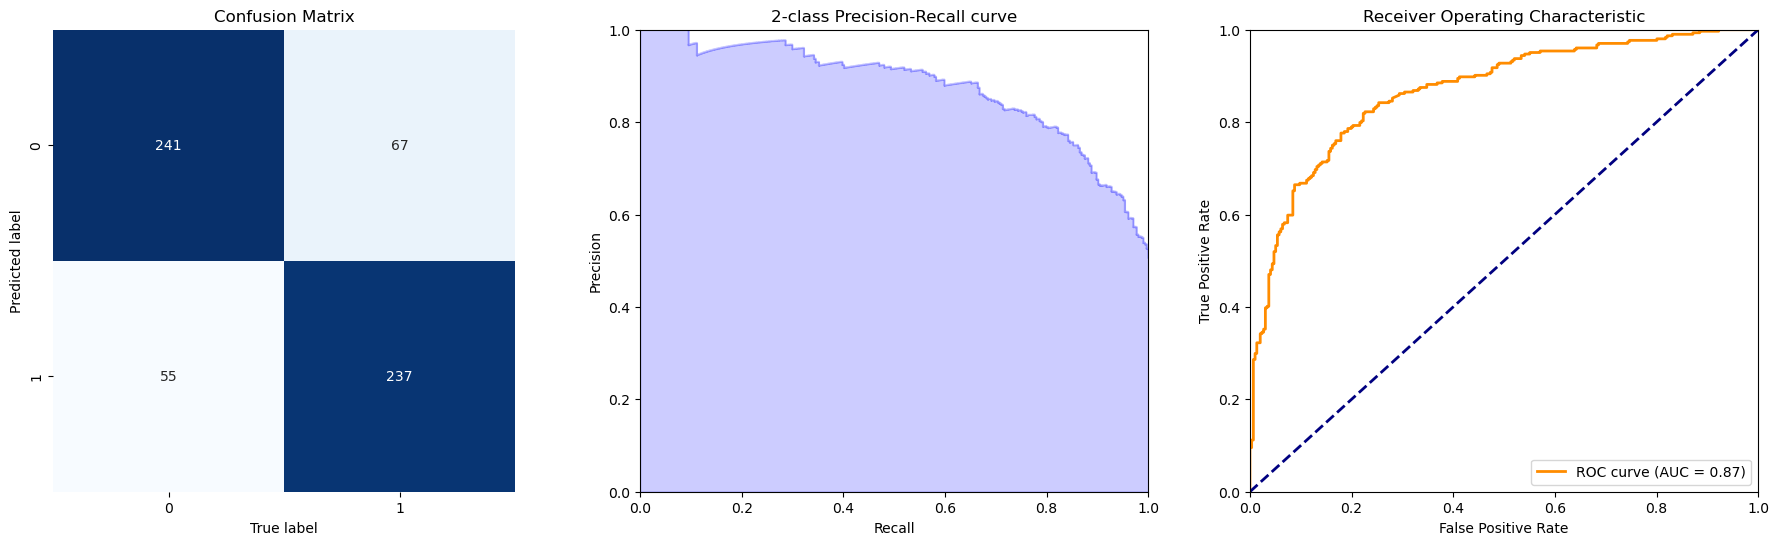

**********
* TF-IDX *
**********
Accuracy : 0.7967 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8116 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7796 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8762                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


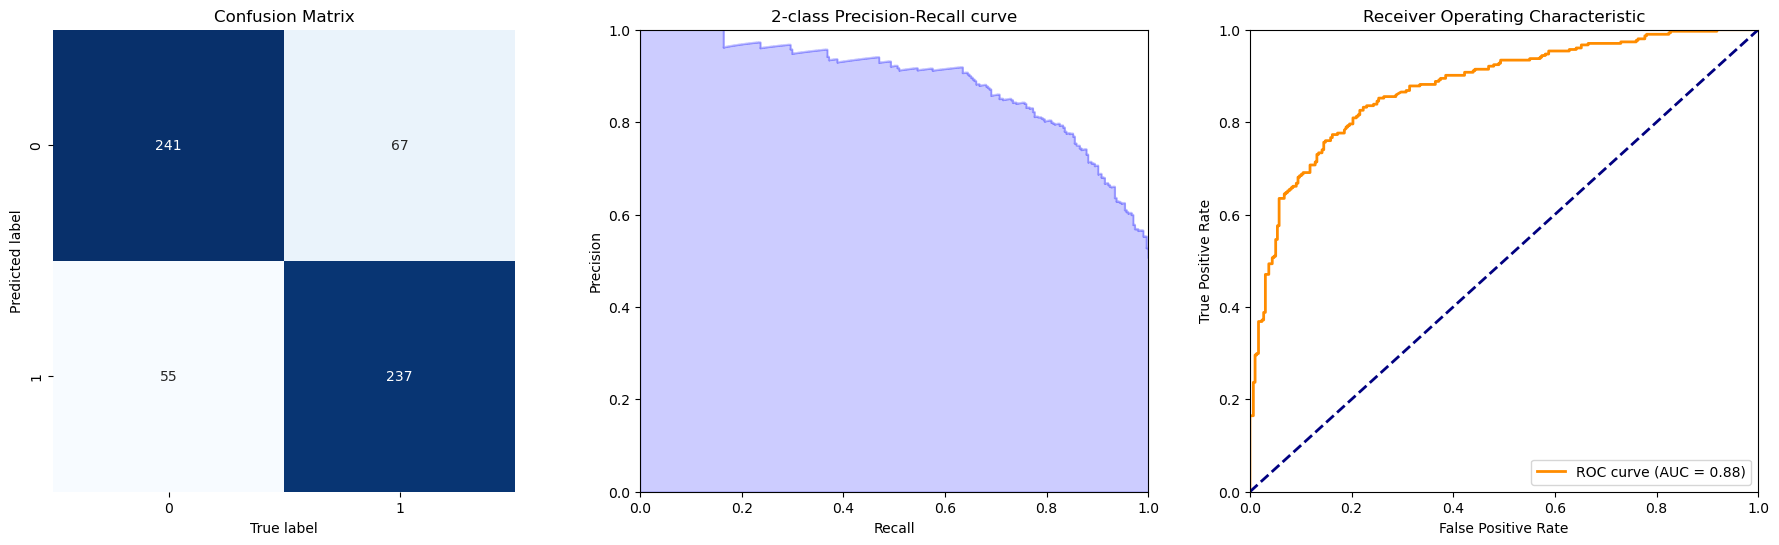

In [139]:
# ANSWER

# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train, y_train)
    # create a classifier using SVC
    classifier = SVC(kernel='linear', probability=True)
    # train the classifier with the training data
    classifier.fit(A, y_train)
    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)
    # make predictions based on the test data
    predictions = classifier.predict(B)
    # store probabilities of predictions being 1
    probabilities = classifier.predict_proba(B)[:, 1]
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}

In [141]:
results


,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.796667,0.811644,0.779605,0.867732
1,TF-IDX,0.796667,0.811644,0.779605,0.876206




---



---



> > > > > > > > > © 2024 Institute of Data


---



---



